In [1]:
import pandas as pd
import mdtraj as md
import numpy as np
from numpy.random import seed
from numpy.random import shuffle
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
from __future__ import print_function
import seaborn as sns
from matplotlib.ticker import NullFormatter, MaxNLocator
import matplotlib.ticker as ticker
import plotly.graph_objects as go
import scipy as sp
from itertools import chain
import matplotlib as mpl
from matplotlib.lines import Line2D
from scipy import spatial
from scipy.spatial import ConvexHull
from scipy.optimize import curve_fit
import scipy.stats as stats
import statsmodels.stats.weightstats
from matplotlib import path
from scipy.stats import probplot,shapiro, sem
import statsmodels.api as sm
from scipy.interpolate import make_interp_spline
from mpl_toolkits.mplot3d.axes3d import Axes3D
from matplotlib.ticker import (AutoMinorLocator, MultipleLocator)
from matplotlib import cm
from numpy import linspace
import umap.umap_ as umap
#import pylab

from scipy import stats
from scipy.stats import pearsonr
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,r2_score, mean_squared_error
from sklearn.metrics import RocCurveDisplay, roc_auc_score
from sklearn.linear_model import RidgeCV
from sklearn.metrics import f1_score, confusion_matrix, ConfusionMatrixDisplay,classification_report
from sklearn.svm import SVC, SVR
from sklearn.preprocessing import LabelEncoder, label_binarize, StandardScaler
import networkx as nx


import os
#import PIL
#from scipy.ndimage import gaussian_filter, uniform_filter1d

# Some Functions

In [2]:
print('THIS IS A GLOBAL VARIABLE. Do not change testeq_GW')
global testeq_GW
testeq_GW= pd.read_csv('../segmented_chain_project/reference_GW_chainlen_100_for_RSA.csv')

THIS IS A GLOBAL VARIABLE. Do not change testeq_GW


In [3]:
se = lambda x : np.std(x)/np.sqrt(x.size)
se.__name__ = 'SE'
hexcolors = ['#EE7733', '#0077BB', '#33BBEE', '#EE3377', '#CC3311', '#009988', '#BBBBBB']
colornames = ['orange','blue','cyan','magenta','red','teal','grey']
pt_colors = dict(zip(colornames,hexcolors))
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Arial'] + plt.rcParams['font.sans-serif']
mpl.rcParams['mathtext.fontset'] = 'custom'
mpl.rcParams['mathtext.rm'] = 'Times New Roman'
mpl.rcParams['mathtext.it'] = 'Times New Roman:italic'
mpl.rc('pdf', fonttype=42)

# generate a dataframe connecting directory with seq_name in their property df

In [4]:
seq_name_AFRC = pd.read_csv('../holehouse_project/IDRome_shape_mean_size_mean_added.csv')
seq_name_dir_df = pd.read_csv('../larsen_paper_2023_compaction/seq_name_dir_df.csv')
seq_name_fluctations = pd.read_csv('../larsen_paper_2023_compaction/HPC_computed_fC_values_all.csv').set_index('seq_name_list')
seq_stdev = pd.read_csv('../holehouse_project/IDRome_Rg_Rs_RSA_stdev.csv').set_index('seq_name')
seq_ALBATROSS = pd.read_csv('../holehouse_project/IDRome_with_ALBATROSS_calculations.csv').set_index('seq_name')
seq_ranges = pd.read_csv('../holehouse_project/IDRome_Rg_Rs_RSA_range.csv').set_index('seq_name')
seq_Rs_RSA_min_max = pd.read_csv('../holehouse_project/IDRome_Rs_RSA_min_max.csv').set_index('seq_name')
seq_Rs_12_frac = pd.read_csv('../holehouse_project/IDRome_Rs_frac_greater_than_12.csv').set_index('seq_name')
subchain_metrics = pd.read_csv('../subchain_analysis/subchain_metrics_df_combined.csv').set_index('seq_name')
# the bounded_frac_size_shape is only for size-shape (through pyconformap_modified)


#add fP to the property df
seq_name_AFRC['fP'] = [seq.count('P')/len(seq) for seq in seq_name_AFRC.fasta.values]


seq_name_AFRC['net_charge'] = [(seq.count('K')+seq.count('R')-seq.count('D')-seq.count('E'))/len(seq) for seq in seq_name_AFRC.fasta.values]
seq_name_AFRC['fpos'] = [(seq.count('K')+seq.count('R'))/len(seq) for seq in seq_name_AFRC.fasta.values]
seq_name_AFRC['fneg'] = [(seq.count('D')+seq.count('E'))/len(seq) for seq in seq_name_AFRC.fasta.values]
seq_name_AFRC['faliphatic'] = [(seq.count('I')+seq.count('L')+seq.count('M')+seq.count('V'))/len(seq) for seq in seq_name_AFRC.fasta.values]

idrome_prop_flucs = pd.concat([seq_name_AFRC.set_index('seq_name'),
           seq_name_fluctations[['fC_shape_shape',
                                 'fA_shape_shape',
                                 'fC_size_shape',
                                 'fA_size_shape',
                                 'bounded_frac_size_shape']],
                              seq_stdev[['Rg_std','Rs_std','RSA_std']],
                              seq_ALBATROSS[['albatross_Rg','albatross_Rg_scaled','albatross_Ree','albatross_Ree_scaled',
                                             'albatross_scaling_exponent']],
                              seq_ranges[['Rg_range','Rs_range','RSA_range']],
                              seq_Rs_RSA_min_max[['Rs_min','Rs_max','RSA_min','RSA_max']],
                              seq_Rs_12_frac[['Rs_frac']],subchain_metrics],
          axis=1).reset_index().rename(columns={'index':'seq_name'}).copy()

#compare global vs local subchain metrics
idrome_prop_flucs['glob_loc_fac_nu'] = (idrome_prop_flucs['nu'].values-idrome_prop_flucs['min_mean_nu'].values)/(idrome_prop_flucs['max_mean_nu'].values-idrome_prop_flucs['min_mean_nu'].values)
idrome_prop_flucs['glob_loc_fac_RSA'] = (idrome_prop_flucs['mean_RSA'].values-idrome_prop_flucs['min_mean_RSA'].values)/(idrome_prop_flucs['max_mean_RSA'].values-idrome_prop_flucs['min_mean_RSA'].values)
idrome_prop_flucs['glob_loc_fac_Rs'] = (idrome_prop_flucs['mean_inst_ratio'].values-idrome_prop_flucs['min_mean_Rs'].values)/(idrome_prop_flucs['max_mean_Rs'].values-idrome_prop_flucs['min_mean_Rs'].values)
idrome_prop_flucs['glob_loc_fac_rg_theta_mean'] = (idrome_prop_flucs['rg_rg_theta_mean'].values-idrome_prop_flucs['min_mean_rg_rg_theta'].values)/(idrome_prop_flucs['max_mean_rg_rg_theta'].values-idrome_prop_flucs['min_mean_rg_rg_theta'].values)

del seq_name_fluctations, seq_name_AFRC, seq_stdev, seq_ALBATROSS, seq_Rs_RSA_min_max,seq_Rs_12_frac,subchain_metrics
idrome_prop_flucs

,seq_name,UniProt_ID,N,nu,SPR,ete2_Rg2,S,Delta,Rg/nm,Ree/nm,...,stdev_mean_rg_rg_theta,min_mean_nu,mid_res_min_mean_nu,max_mean_nu,mid_res_max_mean_nu,stdev_mean_nu,glob_loc_fac_nu,glob_loc_fac_RSA,glob_loc_fac_Rs,glob_loc_fac_rg_theta_mean
0,A0A024RBG1_145_181,A0A024RBG1,37,0.558,10.284649,6.304027,0.933961,0.225950,1.606561,3.843011,...,0.014482,0.604528,13.0,0.655475,18.0,0.013469,-0.913241,-1.379114,-1.384175,3.558144
1,A0A075B6T7_1_32,A0A075B6T7,32,0.525,10.092351,6.114494,0.901807,0.212670,1.448141,3.390487,...,0.014967,0.575042,18.0,0.645993,7.0,0.019511,-0.705314,-1.234030,-1.871938,2.175876
2,A0A087WTH1_1_67,A0A087WTH1,67,0.532,10.160125,6.069995,0.822738,0.199126,2.243991,5.283533,...,0.013978,0.524312,19.0,0.592436,47.0,0.024612,0.112855,-0.038903,0.107637,1.418082
3,A0A087WTH5_1_132,A0A087WTH5,132,0.496,10.049124,6.150972,0.798438,0.188978,3.034005,7.119714,...,0.021404,0.518506,50.0,0.587438,113.0,0.019152,-0.326487,-0.750421,0.303032,0.536720
4,A0A087WV53_1_46,A0A087WV53,46,0.567,10.212765,6.439589,0.882210,0.214786,1.882622,4.607908,...,0.017341,0.553039,32.0,0.645676,20.0,0.029551,0.150705,-0.321009,0.334304,2.668049
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28053,Q9Y6Z4_1_181,Q9Y6Z4,181,0.493,10.006512,5.748098,0.799905,0.210890,3.791956,8.607822,...,0.013574,0.542512,165.0,0.597604,85.0,0.015493,-0.898728,-0.643604,-0.265270,1.869392
28054,Q9Y6Z5_1_254,Q9Y6Z5,254,0.528,9.830710,6.153759,0.896173,0.221422,4.586832,10.808776,...,0.018465,0.554747,87.0,0.600955,142.0,0.010665,-0.578841,-0.642560,0.018576,1.633132
28055,Q9Y6Z7_1_109,Q9Y6Z7,109,0.546,10.025622,6.175505,0.935857,0.216970,3.011145,7.113405,...,0.019801,0.507268,16.0,0.624624,46.0,0.028998,0.330041,0.237612,0.202796,1.801725
28056,W6CW81_1_113,W6CW81,113,0.519,10.084249,6.191149,0.843169,0.193880,2.943990,6.975229,...,0.018726,0.546651,41.0,0.577160,60.0,0.007601,-0.906288,-0.674768,-0.008696,1.290650


# write function

In [5]:
# def compute_3dplot_from_seq_name(seq_name):
#     example_protein_dir = seq_name_dir_df[seq_name_dir_df.seq_name==seq_name].seq_dir.values[0]
#     t = md.load(f'{example_protein_dir}/traj.xtc', top=f'{example_protein_dir}/top.pdb')
#     t_df_moments = pd.DataFrame(md.principal_moments(t),columns=['R3','R2','R1']).iloc[10:,:].copy()
#     t_df_moments['asphericity']=t_df_moments.R1.values-(0.5*(t_df_moments.R2.values+t_df_moments.R3.values))
#     t_df_moments['acylindricity']=t_df_moments.R2.values-t_df_moments.R3.values
#     t_df_moments['RSA']=(t_df_moments.asphericity.values**2+(0.75*t_df_moments.acylindricity.values**2))/(t_df_moments.R1.values+t_df_moments.R2.values+t_df_moments.R3.values)**2
#     protein_df = t_df_moments[['RSA']].copy()
#     del t_df_moments
#     protein_df['Rg2'] = np.load(f'{example_protein_dir}/rg.npy')**2
#     protein_df['Ree2'] = np.load(f'{example_protein_dir}/ete.npy')**2
#     protein_df['ratio'] = protein_df['Ree2']/protein_df['Rg2']
#     #plt.close()
#     return protein_3dplot_against_GW(protein_df,seq_name,'protein','magenta')

In [6]:
def get_grid_protein(seq_name):
    example_protein_dir = seq_name_dir_df[seq_name_dir_df.seq_name==seq_name].seq_dir.values[0]
    t = md.load(f'{example_protein_dir}/traj.xtc', top=f'{example_protein_dir}/top.pdb')
    t_df_moments = pd.DataFrame(md.principal_moments(t),columns=['R3','R2','R1']).iloc[10:,:].copy()
    t_df_moments['asphericity']=t_df_moments.R1.values-(0.5*(t_df_moments.R2.values+t_df_moments.R3.values))
    t_df_moments['acylindricity']=t_df_moments.R2.values-t_df_moments.R3.values
    t_df_moments['RSA']=(t_df_moments.asphericity.values**2+(0.75*t_df_moments.acylindricity.values**2))/(t_df_moments.R1.values+t_df_moments.R2.values+t_df_moments.R3.values)**2
    protein_df = t_df_moments[['RSA']].copy()
    del t_df_moments    

    protein_df['Rg2'] = np.load(f'{example_protein_dir}/rg.npy')**2
    protein_df['Ree2'] = np.load(f'{example_protein_dir}/ete.npy')**2
    protein_df['ratio'] = protein_df['Ree2']/protein_df['Rg2']    
    
    protein_rg2 = np.load(f'{example_protein_dir}/rg.npy')**2
    protein_ree2 = np.load(f'{example_protein_dir}/ete.npy')**2
    protein_ratio = protein_ree2/protein_rg2
    protein_rg_mean = np.mean(np.load(f'{example_protein_dir}/rg.npy'))
    protein_rg_by_rg_mean = np.load(f'{example_protein_dir}/rg.npy')/protein_rg_mean
    global grid_protein_size_shape, grid_protein_shape_shape, grid_protein_rg_rg_mean, grid_protein_Rs,grid_protein_RSA
    x_polmodel_GW=[]
    y_polmodel_GW=[]
    x_total=[]
    y_total=[]
    p_total = []
    q_total = []
    GW_rg = testeq_GW['Rg2']**0.5
    GW_rg_mean = GW_rg.mean()
    GW_rg_by_rg_mean = GW_rg/GW_rg_mean
    x_polmodel_GW.append(GW_rg_by_rg_mean)
    y_polmodel_GW.append(testeq_GW['ratio'].values)

    x_total.append(protein_rg_by_rg_mean)
    y_total.append(protein_ratio)
    p_total.append(protein_df.RSA.values)
    q_total.append(protein_df.ratio.values)
    
    x_total=list(chain.from_iterable(x_total))
    y_total=list(chain.from_iterable(y_total))
    x_polmodel_GW=list(chain.from_iterable(x_polmodel_GW))
    y_polmodel_GW=list(chain.from_iterable(y_polmodel_GW))
    p_total=list(chain.from_iterable(p_total))
    q_total=list(chain.from_iterable(q_total))
    
#size shape portion
    max_x_val=3
    max_y_val=30
    xlims = [0,max_x_val]
    ylims = [0,max_y_val]
    step_x=0.3#(min(x_polmodel_GW)-max(x_polmodel_GW))/original_n_divisions
    step_y=3#(
    max_value_x=max(xlims)
    n_divisions_x=round((max_value_x-min(xlims))/step_x)
    
    max_value_y=max(ylims)
    n_divisions_y=round((max_value_y-min(ylims))/step_y)
    #gridx = np.linspace(min(x_polmodel_GW), max(x_polmodel_GW), n_divisions_x)
    gridx = np.linspace(min(xlims), max(xlims), n_divisions_x+1)
    #gridy = np.linspace(min(y_polmodel_GW), max(y_polmodel_GW), n_divisions_y)
    gridy = np.linspace(min(ylims), max(ylims), n_divisions_y+1)
    
    grid_protein_size_shape, _, _ = np.histogram2d(x_total, y_total, bins=[gridx, gridy])
    #isolate the variable grids
    grid_protein_rg_rg_mean,_ = np.histogram(x_total,bins=gridx)
    grid_protein_Rs,_ = np.histogram(y_total,bins=gridy)
    
    grid_GW, _, _ = np.histogram2d(x_polmodel_GW, y_polmodel_GW, bins=[gridx, gridy])
    del xlims, ylims, max_x_val, max_y_val, n_divisions_x, n_divisions_y, step_x, step_y, gridx, gridy
#shape shape portion
    max_p_val=1
    max_q_val=30
    plims = [0,max_p_val]
    qlims = [0,max_q_val]
    
    step_p=0.1
    step_q=3
    max_value_p=max(plims)
    n_divisions_p=round((max_value_p-min(plims))/step_p)
    
    max_value_q=max(qlims)
    n_divisions_q=round((max_value_q-min(qlims))/step_q)
    
    gridp = np.linspace(min(plims), max(plims), n_divisions_p+1)
    gridq = np.linspace(min(qlims), max(qlims), n_divisions_q+1)
    
    grid_protein_shape_shape, _, _ = np.histogram2d(p_total, q_total, bins=[gridp, gridq])
    grid_protein_RSA,_ = np.histogram(p_total,bins=gridp)
    
    return

In [7]:
def compile_umap_df(provided_seq_list):
    j=0
    for provided_seq in provided_seq_list:
        if j==0:
            get_grid_protein(provided_seq)
            current_df_size = pd.DataFrame(grid_protein_rg_rg_mean,index=[f'size+{j}' for j in range(len(grid_protein_rg_rg_mean))]).T
            current_df_Rs = pd.DataFrame(grid_protein_Rs,index=[f'ratio+{j}' for j in range(len(grid_protein_Rs))]).T
            current_df_RSA = pd.DataFrame(grid_protein_RSA,index=[f'RSA+{j}' for j in range(len(grid_protein_RSA))]).T        
            current_df_total = pd.concat([current_df_size,current_df_Rs,current_df_RSA],axis=1)
            current_df_total.insert(0,'peptID',provided_seq)
            master_df = current_df_total.copy()
        else:
            get_grid_protein(provided_seq)
            current_df_size = pd.DataFrame(grid_protein_rg_rg_mean,index=[f'size+{j}' for j in range(len(grid_protein_rg_rg_mean))]).T
            current_df_Rs = pd.DataFrame(grid_protein_Rs,index=[f'ratio+{j}' for j in range(len(grid_protein_Rs))]).T
            current_df_RSA = pd.DataFrame(grid_protein_RSA,index=[f'RSA+{j}' for j in range(len(grid_protein_RSA))]).T        
            current_df_total = pd.concat([current_df_size,current_df_Rs,current_df_RSA],axis=1)
            current_df_total.insert(0,'peptID',provided_seq)
            master_df = pd.concat([master_df,current_df_total]).copy()
        j+=1
    return master_df

In [8]:
#two functions here -- to plot 2d map
def RSA_based_fC(protein_var,protein_name,poly_id,
                       GW_moment_var,every_ith_snap,GW_every_ith_snap,radius_):
    x_total=[]
    y_total=[]
    if poly_id=='protein':
        protein_label=protein_name
        temp_protein=protein_var.copy()
        x_total.append(temp_protein.RSA.values)
        y_total.append(temp_protein.ratio.values)
        x_total=list(chain.from_iterable(x_total))
        y_total=list(chain.from_iterable(y_total))
        poly_var=protein_var.copy()
        protein_pro=poly_var[['ratio','RSA']].iloc[:every_ith_snap,:].copy()
        protein_pro['polymer_id']=np.repeat(protein_label,protein_pro.shape[0])
        del x_total, y_total, temp_protein
    else:
        return print('ERROR')

    GW_po=GW_moment_var[['ratio','RSA']][::GW_every_ith_snap].copy()
    GW_po['polymer_id']=np.repeat('GW',GW_po.shape[0])
    
    #calculate mean and stdev values (must keep same mean and stdev values)
    upto_snapshots=1000000
    GW_mean_ratio=np.mean(GW_po['ratio'].values[0:(upto_snapshots+1)])
    GW_std_ratio=np.std(GW_po['ratio'].values[0:(upto_snapshots+1)])
    GW_mean_RSA=np.mean(GW_po['RSA'].values[0:(upto_snapshots+1)])
    GW_std_RSA=np.std(GW_po['RSA'].values[0:(upto_snapshots+1)])
        
    combined_pro_po=pd.concat([GW_po,protein_pro],axis=0,ignore_index=True)
    combined_pro_po['stdd_ratio']=(combined_pro_po['ratio'].values-GW_mean_ratio)/(GW_std_ratio)
    combined_pro_po['stdd_RSA']=(combined_pro_po['RSA'].values-GW_mean_RSA)/(GW_std_RSA)
    po_x=combined_pro_po[combined_pro_po.polymer_id=='GW']['stdd_RSA'].values
    po_y=combined_pro_po[combined_pro_po.polymer_id=='GW']['stdd_ratio'].values
    pro_x=combined_pro_po[combined_pro_po.polymer_id==protein_label]['stdd_RSA'].values
    pro_y=combined_pro_po[combined_pro_po.polymer_id==protein_label]['stdd_ratio'].values
    
    GW_points=np.c_[po_x, po_y]
    protein_points=np.c_[pro_x, pro_y]    
    tree_GW=spatial.cKDTree(GW_points)
    tree_protein=spatial.cKDTree(protein_points)

    GW_not_in_range=[]
    j=0
    for point in GW_points:

        if not tree_protein.query_ball_point(point,radius_):
            GW_not_in_range.append(point)
        j+=1
        if j%1000000==0:
            print(f'{j} GW snapshots completed')
                
    fC_by_distance=(GW_points.shape[0]-len(GW_not_in_range))/(GW_points.shape[0])
    return fC_by_distance    
def protein_3dplot_against_GW(protein_var,protein_label,second_obj,provided_color):
    
    x_variable= 'RSA'
    y_variable=r'$R_s$'
    global fC_value, grid_protein, grid_GW

    testeq_GW= pd.read_csv('../segmented_chain_project/reference_GW_chainlen_100_for_RSA.csv')
    
    plt.rcParams["font.weight"] = "regular"
    plt.rcParams["axes.labelweight"] = "regular"
    
    
    x_polmodel_GW=[]
    y_polmodel_GW=[]
    x_total=[]
    y_total=[]

    scatter_markers=['d','x',4,'o','v','^','1','8','s','p','P','*','X','D',9]


    x_polmodel_GW.append(testeq_GW['RSA'].values)
    y_polmodel_GW.append(testeq_GW['ratio'].values)

    if second_obj=='protein':        
        temp_protein =  protein_var.copy()

        x_total.append(temp_protein.RSA.values)
        y_total.append(temp_protein.ratio.values)

        fC_value=RSA_based_fC(temp_protein,
                       protein_label,
                       second_obj,testeq_GW,
                       temp_protein.shape[0],
                       1,0.1)            
        del temp_protein
    else:
        print('ERROR. FIX ERROR')

    x_total=list(chain.from_iterable(x_total))
    y_total=list(chain.from_iterable(y_total))
    x_polmodel_GW=list(chain.from_iterable(x_polmodel_GW))
    y_polmodel_GW=list(chain.from_iterable(y_polmodel_GW))

    # Set up default x and y limits
    max_x_val=1
    max_y_val=30
    xlims = [0,max_x_val]
    ylims = [0,max_y_val]
    if testeq_GW['RSA'].max()>max_x_val or testeq_GW['RSA'].min()<0:
        return print('ERROR')
    elif max(x_total)>max_x_val or min(x_total)<0:
        return print('ERROR')        
    elif testeq_GW['ratio'].max()>max_y_val or testeq_GW['ratio'].min()<0:
        return print('ERROR')
    elif max(y_total)>max_y_val or min(y_total)<0:
        return print('ERROR')        

    # Set up your x and y labels
    xlabel = x_variable
    ylabel = y_variable

    # Define the locations for the axes

    left, width = 0.12, 0.55
    bottom, height = 0.12, 0.55
    bottom_h = left_h = left+width
    rect_temperature = [left, bottom, width, height] # dimensions of temp plot
    rect_histx = [left, bottom_h, width, 0.25] # dimensions of x-histogram
    rect_histy = [left_h, bottom, 0.25, height] # dimensions of y-histogram


    # Set up the size of the figure
    fig = plt.figure(1, figsize=(5.2,5))

    # Make the three plots
    axTemperature = plt.axes(rect_temperature) # temperature plot
    axHistx = plt.axes(rect_histx) # x histogram
    axHisty = plt.axes(rect_histy) # y histogram


    axHistx.axes.get_xaxis().set_visible(False)
    axHisty.axes.get_yaxis().set_visible(False)


    # Find the min/max of the data
    xmin = min(xlims)
    xmax = max(xlims)
    ymin = min(ylims)
    ymax = max(ylims)

    # Remove the inner axes numbers of the histograms
    nullfmt = NullFormatter()
    #
    # Define the number of bins
    nxbins = 100
    nybins = 50
    nbins = nxbins+nybins

    xbins = linspace(start = xmin, stop = xmax, num = nxbins)
    ybins = linspace(start = ymin, stop = ymax, num = nybins)
    xcenter = (xbins[0:-1]+xbins[1:])/2.0
    ycenter = (ybins[0:-1]+ybins[1:])/2.0
    aspectratio = (1.0*(xmax - 0))/(1.38*ymax - 0)


    X = xcenter
    Y = ycenter

    axTemperature.scatter(x_polmodel_GW,y_polmodel_GW,
                      marker=scatter_markers[3],s=1,alpha=0.6,color='black',
                       label='GW')
    
    axTemperature.scatter(x_total,
               y_total,
               marker=scatter_markers[0],s=1,alpha=0.6,color=provided_color,
                                      label=protein_label)                



    #Plot the axes labels
    axTemperature.set_xlabel(xlabel,fontsize=12,labelpad = 1)
    axTemperature.set_ylabel(ylabel,fontsize=12, labelpad = 1)

    #Set up the plot limits
    axTemperature.set_xlim(xlims)
    axTemperature.set_ylim(ylims)

    #Set up the histogram bins
    xbins = np.arange(xmin, xmax, (xmax-xmin)/nbins)
    ybins = np.arange(ymin, ymax, (ymax-ymin)/nbins)


    axHistx.hist(x_polmodel_GW, bins=xbins, color = 'black',histtype='step',
                linewidth = 0.7,density=True)
    axHistx.hist(x_total, bins=xbins, color = provided_color,histtype='step',
                label=protein_label,linewidth = 0.7,density=True)

    axHisty.hist(y_polmodel_GW, bins=np.arange(min(y_total),max(y_total),1), color = 'black',orientation='horizontal',histtype='step',
                linewidth = 0.7,density=True)

    axHisty.hist(y_total, bins=ybins, color = provided_color,orientation='horizontal',histtype='step',
                label=protein_label,linewidth = 0.7,density=True)    
    
    #original_n_divisions=100
    step_x=0.02#(min(x_polmodel_GW)-max(x_polmodel_GW))/original_n_divisions
    step_y=0.6#(min(y_polmodel_GW)-max(y_polmodel_GW))/original_n_divisions
    max_value_x=max(xlims)
    n_divisions_x=round((max_value_x-min(xlims))/step_x)
    
    max_value_y=max(ylims)
    n_divisions_y=round((max_value_y-min(ylims))/step_y)
    #gridx = np.linspace(min(x_polmodel_GW), max(x_polmodel_GW), n_divisions_x)
    gridx = np.linspace(min(xlims), max(xlims), n_divisions_x)
    #gridy = np.linspace(min(y_polmodel_GW), max(y_polmodel_GW), n_divisions_y)
    gridy = np.linspace(min(ylims), max(ylims), n_divisions_y)
    
    grid_protein, _, _ = np.histogram2d(x_total, y_total, bins=[gridx, gridy])
    grid_GW, _, _ = np.histogram2d(x_polmodel_GW, y_polmodel_GW, bins=[gridx, gridy])

    axTemperature.text(0.7,0.8,
                       '$f_C$= '+format(fC_value,'0.3f'),
                      transform=axTemperature.transAxes,fontsize=8)
    axTemperature.text(0.7,0.74,
                       '$f_A$= '+format(np.count_nonzero(grid_protein)/np.count_nonzero(grid_GW),'0.3f'),
                      transform=axTemperature.transAxes,fontsize=8)    

    axTemp_legend=axTemperature.legend(fontsize=7,loc='upper right')

    frame = axTemp_legend.get_frame()
    frame.set_linewidth(1)
    frame.set_edgecolor('black')
    #axHisty.hist(y, bins=ybins, orientation='horizontal', color = provided_color)






    #Set up the histogram limits
    axHistx.set_xlim( xmin, xmax )
    axHisty.set_ylim( ymin, ymax )

    axHistx.set_ylabel('Prob. Density',fontsize=12)
    axHisty.set_xlabel('Prob. Density',fontsize=12)


    #Cool trick that changes the number of tickmarks for the histogram axes
    axHisty.xaxis.set_major_locator(MaxNLocator(4))
    axHistx.yaxis.set_major_locator(MaxNLocator(3))

    for i in ['top', 'left', 'right', 'bottom']:
        axHistx.spines[i].set_linewidth(1)
        axHisty.spines[i].set_linewidth(1)
        axTemperature.spines[i].set_linewidth(1)

    axHistx.minorticks_on()
    axHistx.tick_params(axis='y', which='major', labelsize=10, width = 0.8, pad = 2)
    axHistx.tick_params(axis='y', which='minor', width = 0.6)
    axHisty.minorticks_on()
    axHisty.tick_params(axis='x', which='major', labelsize=10, width = 0.8, pad = 2,labelrotation=270)
    axHisty.tick_params(axis='x', which='minor', width = 0.6)
    axTemperature.minorticks_on()
    axTemperature.tick_params(axis='both', which='major', labelsize=10, width = 0.8, pad = 2)
    axTemperature.tick_params(axis='both', which='minor', width = 0.6)    
    plt.setp(axTemperature.get_yticklabels()[-1], visible=False)
    plt.setp(axTemperature.get_xticklabels()[-1], visible=False)
    #fig.subplots_adjust(hspace=0.85,wspace=0.85)

    # Save to a File
    filename = 'GW_3d_plot'
    #plt.savefig(f'figures/GW_{protein_label}_3dplot.png', dpi = 1000, bbox_inches='tight')
    return 



In [9]:
def compute_3dplot_from_seq_name(seq_name):
    example_protein_dir = seq_name_dir_df[seq_name_dir_df.seq_name==seq_name].seq_dir.values[0]
    t = md.load(f'{example_protein_dir}/traj.xtc', top=f'{example_protein_dir}/top.pdb')
    t_df_moments = pd.DataFrame(md.principal_moments(t),columns=['R3','R2','R1']).iloc[10:,:].copy()
    t_df_moments['asphericity']=t_df_moments.R1.values-(0.5*(t_df_moments.R2.values+t_df_moments.R3.values))
    t_df_moments['acylindricity']=t_df_moments.R2.values-t_df_moments.R3.values
    t_df_moments['RSA']=(t_df_moments.asphericity.values**2+(0.75*t_df_moments.acylindricity.values**2))/(t_df_moments.R1.values+t_df_moments.R2.values+t_df_moments.R3.values)**2
    protein_df = t_df_moments[['RSA']].copy()
    del t_df_moments
    protein_df['Rg2'] = np.load(f'{example_protein_dir}/rg.npy')**2
    protein_df['Ree2'] = np.load(f'{example_protein_dir}/ete.npy')**2
    protein_df['ratio'] = protein_df['Ree2']/protein_df['Rg2']
    return protein_3dplot_against_GW(protein_df,seq_name,'protein','magenta')

# get 2d conformation shape plot at different nu values (run in order, see j value in each cell) (ALL ~28000 sequences)

In [7]:
%%time
#do not run

#all_seq_list = seq_name_dir_df['seq_name'].to_list()
#master_df = compile_umap_df(all_seq_list).copy()

CPU times: user 1h 35min 22s, sys: 3min 55s, total: 1h 39min 18s
Wall time: 1h 54min 59s


In [8]:
#do not run 
#master_df = master_df.reset_index(drop=True)
#master_df

,peptID,size+0,size+1,size+2,size+3,size+4,size+5,size+6,size+7,size+8,...,RSA+0,RSA+1,RSA+2,RSA+3,RSA+4,RSA+5,RSA+6,RSA+7,RSA+8,RSA+9
0,H0YL14_1_46,0,0,339,499,148,14,0,0,0,...,21,105,181,170,170,155,109,70,19,0
1,H0YL09_1_131,0,2,365,442,168,23,0,0,0,...,34,146,189,170,181,125,79,64,12,0
2,H0YKK7_1_89,0,3,378,435,157,27,0,0,0,...,29,127,156,157,171,140,122,74,23,1
3,H0YKK7_135_164,0,0,338,509,145,8,0,0,0,...,20,100,163,164,181,141,129,74,28,0
4,H0YKK7_430_550,0,0,352,488,143,17,0,0,0,...,25,116,156,185,168,152,116,67,15,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28053,A3QJZ6_111_153,0,1,362,475,147,15,0,0,0,...,20,116,161,169,154,150,112,85,33,0
28054,A3QJZ7_106_152,0,0,356,462,162,20,0,0,0,...,35,140,172,169,160,132,106,67,18,1
28055,A3KN83_1001_1044,0,1,353,487,149,9,1,0,0,...,22,110,185,150,159,140,129,85,20,0
28056,A3KN83_1_250,0,4,352,477,150,15,2,0,0,...,23,121,174,163,185,165,100,58,11,0


In [6]:
##master_df.to_csv('all_seq_box_df_using_size-shape-shape-individually.csv')
#master_df = pd.read_csv('all_seq_box_df_using_size-shape-shape-individually.csv')
#master_df = master_df.reset_index(drop=True)

In [9]:
#idrome_prop_df = pd.read_csv('combined_idrome_prop_df.csv')
#idrome_prop_df = pd.concat([master_df.set_index('peptID'),idrome_prop_df.set_index('seq_name')],axis=1)
#del master_df

In [8]:
#idrome_prop_df['extra_nu_cat']=['<=0.45' if nu_<=0.45 else '>0.55' if nu_>0.55 else '>0.45 & <=0.55' for nu_ in idrome_prop_df.nu.values]

# looking into some properties

# lets look at mean_lambda

In [10]:
idrome_prop_df.columns

Index(['seq_name', 'UniProt_ID', 'N', 'nu', 'SPR', 'ete2_Rg2', 'S', 'Delta',
       'Rg/nm', 'Ree/nm', 'Rh/nm', 'fK', 'fR', 'fE', 'fD', 'faro',
       'mean_lambda', 'shd', 'scd', 'kappa', 'fcr', 'ncpr', 'fasta',
       'is_btw_folded', 'is_nterm', 'is_cterm', 'is_idp', 'first', 'last',
       'N_FL', 'protein_name', 'gene_name', 'QCDpred', 'z_delta_+-',
       'z_omega_pi', 'z_omega_+', 'z_omega_-', 'z_omega_h', 'fdomain',
       'nu_svr', 'SPR_svr', 'nu_err', 'S_err', 'Delta_err', 'ete2_Rg2_err',
       'Rg', 'Rg_err', 'ete', 'ete_err', 'rh', 'rh_err', 'R0', 'R0_err',
       'SPR_err'],
      dtype='object')

# this is for GO analysis

In [10]:
# load IDRome database
df_idrome = pd.read_csv('IDRome_DB.csv',index_col=0)
df_idrome

,UniProt_ID,N,nu,SPR,ete2_Rg2,S,Delta,Rg/nm,Ree/nm,Rh/nm,...,gene_name,QCDpred,z_delta_+-,z_omega_pi,z_omega_+,z_omega_-,z_omega_h,fdomain,nu_svr,SPR_svr
seq_name,,,,,,,,,,,,,,,,,,,,,
A0A024RBG1_145_181,A0A024RBG1,37,0.558,10.284649,6.304027,0.933961,0.225950,1.606561,3.843011,1.403521,...,NUDT4B,0.254463,0.000000,0.000000,0.000000,0.000000,-0.531910,0.000000,0.565,10.288
A0A075B6T7_1_32,A0A075B6T7,32,0.525,10.092351,6.114494,0.901807,0.212670,1.448141,3.390487,1.308675,...,TRAV6,0.659342,0.000000,0.054230,-0.043142,0.000000,0.061436,0.000000,0.532,10.107
A0A087WTH1_1_67,A0A087WTH1,67,0.532,10.160125,6.069995,0.822738,0.199126,2.243991,5.283533,1.849274,...,TMEM265,0.661272,-1.094918,0.000000,0.384885,2.281943,1.092688,0.298507,0.537,10.167
A0A087WTH5_1_132,A0A087WTH5,132,0.496,10.049124,6.150972,0.798438,0.188978,3.034005,7.119714,2.471343,...,KCNE1B,0.445861,0.000000,-0.463316,0.799692,0.000000,0.627563,0.000000,0.509,10.018
A0A087WV53_1_46,A0A087WV53,46,0.567,10.212765,6.439589,0.882210,0.214786,1.882622,4.607908,1.582147,...,SPEGNB,0.313998,0.000000,0.000000,1.947253,0.000000,0.090132,0.369565,0.578,10.316
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Q9Y6Z4_1_181,Q9Y6Z4,181,0.493,10.006512,5.748098,0.799905,0.210890,3.791956,8.607822,2.953329,...,KIF25-AS1,0.396007,0.000000,0.000000,-1.319891,0.000000,0.163169,0.000000,0.520,9.993
Q9Y6Z5_1_254,Q9Y6Z5,254,0.528,9.830710,6.153759,0.896173,0.221422,4.586832,10.808776,3.457226,...,AFDN-DT,0.374082,0.000000,0.000000,-2.182869,0.000000,2.214949,0.000000,0.537,9.984
Q9Y6Z7_1_109,Q9Y6Z7,109,0.546,10.025622,6.175505,0.935857,0.216970,3.011145,7.113405,2.351117,...,COLEC10,0.232155,0.106768,0.000000,0.451957,2.132808,1.114749,0.513761,0.513,10.072


In [11]:
GO_terms = pd.Series(pd.read_pickle('uniprot_dict.pkl')).to_dict()

In [14]:
GO_terms

{'A0A024RBG1': ['GO:0005737',
  'GO:0005829',
  'GO:0005634',
  'GO:0034431',
  'GO:0034432',
  'GO:0008486',
  'GO:0000298',
  'GO:0050072',
  'GO:0046872',
  'GO:0003723',
  'GO:1901911',
  'GO:1901909',
  'GO:1901907',
  'GO:0071543'],
 'A0A075B6T7': ['GO:0042101', 'GO:0002250', 'GO:0009617'],
 'A0A087WTH1': ['GO:0016021'],
 'A0A087WTH5': ['GO:0016021',
  'GO:0015459',
  'GO:0044325',
  'GO:0005249',
  'GO:0086011',
  'GO:0098915',
  'GO:1902260',
  'GO:0097623',
  'GO:0086091',
  'GO:0060307',
  'GO:0086005'],
 'A0A087WUL8': ['GO:0005737'],
 'A0A087WV53': ['unknown'],
 'A0A087WVF3': ['GO:0005886', 'GO:0005096', 'GO:0090630'],
 'A0A087WWA1': ['GO:0005942', 'GO:0046935', 'GO:0046854'],
 'A0A087WX78': ['unknown'],
 'A0A087WXM9': ['GO:0000779',
  'GO:0000776',
  'GO:0016321',
  'GO:0045143',
  'GO:0007060',
  'GO:0010789',
  'GO:0051754'],
 'A0A087WXS9': ['GO:0005886', 'GO:0005096', 'GO:0090630'],
 'A0A087X179': ['GO:0005886', 'GO:0005096', 'GO:0090630'],
 'A0A087X1G2': ['GO:0005886', 

In [15]:
#function written by Giulio Tesei
import urllib.parse
import urllib.request
import json

def map_to_curated_codes(graph, GO_terms, curated_GO_codes, nodes):
    new_codes = np.empty(0)
    for code in GO_terms:
        if code in nodes and code != 'unknown':
            ancestors = list(nx.dfs_predecessors(graph, source=code, depth_limit=None).values())
            ancestors += list(nx.dfs_predecessors(graph, source=code, depth_limit=None).keys())
            intersect = np.intersect1d(ancestors, curated_GO_codes)
            if intersect.size==0:
                intersect = np.append(intersect, 'other')
            new_codes = np.append(new_codes, intersect)
    return np.unique(new_codes).tolist()

def uniprot_api(uniprot):
    # Use the uniprot as input to fetch the protein name
    url_template_uniprot = "https://rest.uniprot.org/uniprotkb/{}.json"
    url_uniprot = url_template_uniprot.format(uniprot)

    with urllib.request.urlopen(url_uniprot) as link:
        #print(f'Extracting protein name for {uniprot}...')
        data_uniprot = json.loads(link.read().decode())
        #print(data_uniprot)

        try:
            go_list = []
            for count,value in enumerate(data_uniprot['uniProtKBCrossReferences']):
                if data_uniprot['uniProtKBCrossReferences'][count]["database"] == "GO":
                    go_id = data_uniprot['uniProtKBCrossReferences'][count]["id"]
                    #print(go_id)
                    go_list.append(go_id)
        except:
            go_id = "unknown"
            go_list.append(go_id)


        if len(go_list) == 0:
            go_id = "unknown"
            go_list.append(go_id)

        return go_list

In [22]:
for i,uniprot in enumerate(df_idrome.UniProt_ID.unique()):
    go = uniprot_api(uniprot)
    GO_terms[uniprot] = go
    print(i,end='-')

0-1-2-3-4-5-6-7-8-9-10-11-12-13-14-15-16-17-18-19-20-21-22-23-24-25-26-27-28-29-30-31-32-33-34-35-36-37-38-39-40-41-42-43-44-45-46-47-48-49-50-51-52-53-54-55-56-57-58-59-60-61-62-63-64-65-66-67-68-69-70-71-72-73-74-75-76-77-78-79-80-81-82-83-84-85-86-87-88-89-90-91-92-93-94-95-96-97-98-99-100-101-102-103-104-105-106-107-108-109-110-111-112-113-114-115-116-117-118-119-120-121-122-123-124-125-126-127-128-129-130-131-132-133-134-135-136-137-138-139-140-141-142-143-144-145-146-147-148-149-150-151-152-153-154-155-156-157-158-159-160-161-162-163-164-165-166-167-168-169-170-

KeyboardInterrupt: 

In [11]:
df_idrome = pd.read_csv('IDRome_DB.csv',index_col=0)
GO_dict = pd.Series(pd.read_pickle('uniprot_dict.pkl')).to_frame(name='GO')

In [12]:
GO_dict

,GO
A0A024RBG1,"[GO:0005737, GO:0005829, GO:0005634, GO:003443..."
A0A075B6T7,"[GO:0042101, GO:0002250, GO:0009617]"
A0A087WTH1,[GO:0016021]
A0A087WTH5,"[GO:0016021, GO:0015459, GO:0044325, GO:000524..."
A0A087WUL8,[GO:0005737]
...,...
Q9Y6Z4,[unknown]
Q9Y6Z5,[unknown]
Q9Y6Z7,"[GO:0005581, GO:0005737, GO:0009897, GO:000557..."
W6CW81,"[GO:0097169, GO:0003690, GO:0002218, GO:003545..."


In [13]:
GO_dict.loc[df_idrome.UniProt_ID.unique()]

,GO
A0A024RBG1,"[GO:0005737, GO:0005829, GO:0005634, GO:003443..."
A0A075B6T7,"[GO:0042101, GO:0002250, GO:0009617]"
A0A087WTH1,[GO:0016021]
A0A087WTH5,"[GO:0016021, GO:0015459, GO:0044325, GO:000524..."
A0A087WV53,[unknown]
...,...
Q9Y6Z4,[unknown]
Q9Y6Z5,[unknown]
Q9Y6Z7,"[GO:0005581, GO:0005737, GO:0009897, GO:000557..."
W6CW81,"[GO:0097169, GO:0003690, GO:0002218, GO:003545..."


In [14]:
np.unique(GO_dict.loc[df_idrome.UniProt_ID].GO.sum())

array(['GO:0000002', 'GO:0000003', 'GO:0000010', ..., 'GO:2001295',
       'GO:2001311', 'unknown'], dtype='<U10')

In [15]:
GO_dict.loc[df_idrome.UniProt_ID].GO

A0A024RBG1    [GO:0005737, GO:0005829, GO:0005634, GO:003443...
A0A075B6T7                 [GO:0042101, GO:0002250, GO:0009617]
A0A087WTH1                                         [GO:0016021]
A0A087WTH5    [GO:0016021, GO:0015459, GO:0044325, GO:000524...
A0A087WV53                                            [unknown]
                                    ...                        
Q9Y6Z4                                                [unknown]
Q9Y6Z5                                                [unknown]
Q9Y6Z7        [GO:0005581, GO:0005737, GO:0009897, GO:000557...
W6CW81        [GO:0097169, GO:0003690, GO:0002218, GO:003545...
X6R8D5                                                [unknown]
Name: GO, Length: 28058, dtype: object

In [45]:
GO_dict.loc[df_idrome.UniProt_ID].GO.sum()

['GO:0005737',
 'GO:0005829',
 'GO:0005634',
 'GO:0034431',
 'GO:0034432',
 'GO:0008486',
 'GO:0000298',
 'GO:0050072',
 'GO:0046872',
 'GO:0003723',
 'GO:1901911',
 'GO:1901909',
 'GO:1901907',
 'GO:0071543',
 'GO:0042101',
 'GO:0002250',
 'GO:0009617',
 'GO:0016021',
 'GO:0016021',
 'GO:0015459',
 'GO:0044325',
 'GO:0005249',
 'GO:0086011',
 'GO:0098915',
 'GO:1902260',
 'GO:0097623',
 'GO:0086091',
 'GO:0060307',
 'GO:0086005',
 'unknown',
 'GO:0005886',
 'GO:0005096',
 'GO:0090630',
 'GO:0005886',
 'GO:0005096',
 'GO:0090630',
 'GO:0005942',
 'GO:0046935',
 'GO:0046854',
 'unknown',
 'unknown',
 'GO:0000779',
 'GO:0000776',
 'GO:0016321',
 'GO:0045143',
 'GO:0007060',
 'GO:0010789',
 'GO:0051754',
 'GO:0005886',
 'GO:0005096',
 'GO:0090630',
 'GO:0005886',
 'GO:0005096',
 'GO:0090630',
 'GO:0005886',
 'GO:0005096',
 'GO:0090630',
 'GO:0005886',
 'GO:0005096',
 'GO:0090630',
 'GO:0005886',
 'GO:0005096',
 'GO:0090630',
 'GO:0005886',
 'GO:0005096',
 'GO:0090630',
 'GO:0005615',
 'GO

In [10]:
import obonet

In [11]:
url = 'http://purl.obolibrary.org/obo/go/go-basic.obo'
graph = obonet.read_obo(url)

id_to_name = {id_: data.get('name') for id_, data in graph.nodes(data=True)}
name_to_id = {data['name']: id_ for id_, data in graph.nodes(data=True) if 'name' in data}

In [12]:
#print(name_to_id['molecular_function'],name_to_id['biological_process'],name_to_id['cellular_component'])
molfunc = list(nx.ancestors(graph, 'GO:0003674')) # all nodes connected to molecular function
bioproc = list(nx.ancestors(graph, 'GO:0008150')) # all nodes connected to biological process
cellcom = list(nx.ancestors(graph, 'GO:0005575')) # all nodes connected to cellular component

In [13]:
nodes_cat = cellcom

In [13]:
GO_terms = GO_dict.copy() 
    # Copy database
df_GO = df_idrome.copy()

g,u = np.unique(GO_dict.loc[df_idrome.UniProt_ID].GO.sum(),return_counts=True)
curated_GO_codes = g[u>=200]
curated_GO_codes = np.unique(np.intersect1d(curated_GO_codes,nodes_cat))
curated_GO_terms = [id_to_name[x] for x in curated_GO_codes]
GO_terms.GO = GO_terms.GO.apply( lambda x : map_to_curated_codes(graph, x, curated_GO_codes, nodes_cat) )

df_GO['UniProt_ID'] = df_GO.UniProt_ID.apply(lambda x: [x])
df_GO['count_GO_terms'] = df_GO.UniProt_ID.apply(lambda x : len(GO_terms.loc[x].GO.values[0]))
df_GO = df_GO[df_GO['count_GO_terms']>0]
df_GO['GO_terms'] = df_GO.UniProt_ID.apply(
    lambda x : [id_to_name[c] if c!='other' else 'other' for c in GO_terms.loc[x].GO.values[0]])
df_GO.drop('count_GO_terms',axis=1,inplace=True)

print(df_GO.shape[0])

NameError: name 'GO_dict' is not defined

In [14]:
df_GO

NameError: name 'df_GO' is not defined

In [15]:
def populate_table(df,a,b,prop,pvalue,name,n_bootstrap,subsample=False):
    sub = '_sub'
    if not subsample:
        sub = ''
        df.loc[name,prop+'_p'] = pvalue
        if df.loc[name,prop+'_p'] < 1e-5:
            df.loc[name,prop+'_p_excel'] = f'<{1e-5:.1g}'
        else:
            df.loc[name,prop+'_p_excel'] = f'{pvalue:.1g}'
    cohens_d, cohens_d_se, pvalue_b = bootstrap(a,b,n_bootstrap,subsample)
    df.loc[name,prop+'_cd'+sub] = cohens_d
    df.loc[name,prop+'_cd_se'+sub] = cohens_d_se
    df.loc[name,prop+'_p'] = pvalue
    df.loc[name,prop+'_p_b'+sub] = pvalue_b
    df.loc[name,prop+'_cd_excel'+sub] = f'{cohens_d:.2f}±{cohens_d_se:.2f}'
    if df.loc[name,prop+'_p_b'+sub] < 1/n_bootstrap:
        df.loc[name,prop+'_p_b_excel'+sub] = f'<{1/n_bootstrap:.1g}'
    else:
        df.loc[name,prop+'_p_b_excel'+sub] = f'{pvalue_b:.1g}'
def generate_stats_csv(df_idrome,prop_nu,prop_SPR,GO_dict,nodes_cat,label):
    # Copy dict of GO terms for each UniProt ID (see go_analysis/uniprot_API_calls.py)
    GO_terms = GO_dict.copy() 
    # Copy database
    df_GO = df_idrome.copy()
        
    g,u = np.unique(GO_dict.loc[df_idrome.UniProt_ID].GO.sum(),return_counts=True)
    curated_GO_codes = g[u>=200]
    curated_GO_codes = np.unique(np.intersect1d(curated_GO_codes,nodes_cat))
    curated_GO_terms = [id_to_name[x] for x in curated_GO_codes]
    GO_terms.GO = GO_terms.GO.apply( lambda x : map_to_curated_codes(graph, x, curated_GO_codes, nodes_cat) )

    df_GO['UniProt_ID'] = df_GO.UniProt_ID.apply(lambda x: [x])
    df_GO['count_GO_terms'] = df_GO.UniProt_ID.apply(lambda x : len(GO_terms.loc[x].GO.values[0]))
    df_GO = df_GO[df_GO['count_GO_terms']>0]
    df_GO['GO_terms'] = df_GO.UniProt_ID.apply(
        lambda x : [id_to_name[c] if c!='other' else 'other' for c in GO_terms.loc[x].GO.values[0]])
    df_GO.drop('count_GO_terms',axis=1,inplace=True)
    
    print(df_GO.shape[0])
    
    statistics = pd.DataFrame(index=curated_GO_terms)
    n_bootstrap = 100000
    for name in curated_GO_terms:
        bool_term = df_GO.GO_terms.apply(lambda x : name in x).values
        p_nu = stats.brunnermunzel(df_GO[bool_term][prop_nu], 
                        df_GO[~bool_term][prop_nu], alternative='two-sided')[1]/2   
        p_SPR = stats.brunnermunzel(df_GO[bool_term][prop_SPR], 
                        df_GO[~bool_term][prop_SPR], alternative='two-sided')[1]/2
        if p_nu<=1e-5 or p_SPR<=1e-5:
            print(name)
            t0 = time.time()
            for prop,pvalue in zip([prop_nu,prop_SPR],[p_nu,p_SPR]):
                populate_table(statistics,df_GO[bool_term][prop].values, 
                        df_GO[~bool_term][prop].values,prop,pvalue,name,n_bootstrap,subsample=False)
                populate_table(statistics,df_GO[bool_term][prop].values, 
                        df_GO[~bool_term][prop].values,prop,pvalue,name,n_bootstrap,subsample=True)
            print('{:.3f} s'.format(time.time()-t0))
            
    statistics = statistics.sort_values(by=prop_nu+'_p')
    statistics.to_csv(f'GO_stats_{label:s}.csv')
    return df_GO

In [14]:
df_GO_molfunc = pd.read_pickle('df_GO_molfunc.pkl')
df_GO_molfunc = df_GO_molfunc.join(idrome_prop_flucs.set_index('seq_name')['min_mean_nu'])

df_GO_cellcom = pd.read_pickle('df_GO_cellcom.pkl')
df_GO_cellcom = df_GO_cellcom.join(idrome_prop_flucs.set_index('seq_name')['min_mean_nu'])

In [17]:
df_GO_cellcom['min_mean_nu']

seq_name
A0A024RBG1_145_181    0.604528
A0A075B6T7_1_32       0.575042
A0A087WVF3_214_549    0.495899
A0A087WVF3_1_53       0.576936
A0A087WWA1_1_95       0.529269
                        ...   
Q9Y6Y8_595_653        0.602898
Q9Y6Y8_709_773        0.570031
Q9Y6Y8_853_947        0.536807
Q9Y6Z7_1_109          0.507268
W6CW81_1_113          0.546651
Name: min_mean_nu, Length: 25368, dtype: float64

In [32]:
name

'signaling receptor activity'

In [33]:
bool_term = df_GO_molfunc.GO_terms.apply(lambda x : name in x).values

In [36]:
bool_term

(22448,)

In [43]:
bool_term = ((df_GO_molfunc.GO_terms.apply(lambda x: name in x)) &
             ((df_GO_molfunc.min_mean_nu < 0.45) |  (df_GO_molfunc.nu < 0.45)))


0.541

<>:104: SyntaxWarning: invalid escape sequence '\m'
<>:106: SyntaxWarning: invalid escape sequence '\m'
<>:104: SyntaxWarning: invalid escape sequence '\m'
<>:106: SyntaxWarning: invalid escape sequence '\m'
/tmp/ipykernel_2289179/3238118724.py:104: SyntaxWarning: invalid escape sequence '\m'
  ax.set_xlabel('$S_\mathrm{conf}/N$  ($k_B$)')
/tmp/ipykernel_2289179/3238118724.py:106: SyntaxWarning: invalid escape sequence '\m'
  ax.set_ylabel('$P(S_\mathrm{conf}/N)$')
/tmp/ipykernel_2289179/3238118724.py:54: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  legend = ax.legend(handlelength=0,frameon=False,borderpad=0,loc=(-.03,.24))
/tmp/ipykernel_2289179/3238118724.py:96: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  legend = ax.legend(handlelen

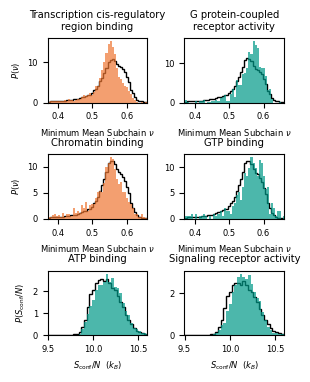

In [51]:
f, axes = plt.subplots(3, 2, sharex=False, sharey=False, figsize=(3,3.8))
plt.rc('font', **{'family':'sans-serif','sans-serif':['Arial'], 'size': 6})

# df_molfunc = pd.read_csv('GO_stats_molfunc.csv',index_col=0)
# df_molfunc.nu_p_excel = df_molfunc.nu_p.apply(lambda x: f'<{1e-10:.1g}' if x<1e-10 else f'{x:.1g}')
# df_molfunc.SPR_p_excel = df_molfunc.SPR_p.apply(lambda x: f'<{1e-10:.1g}' if x<1e-10 else f'{x:.1g}')

bin_width = .006
bins = np.arange(0.25, .74,bin_width)
x = bins[:-1]+bin_width/2.

for name,ax in zip(['transcription cis-regulatory region binding','G protein-coupled receptor activity',
                    'chromatin binding','GTP binding'],axes.flatten()):
    
    bool_term = df_GO_molfunc.GO_terms.apply(lambda x: name in x) 
    a = df_GO_molfunc[bool_term].min_mean_nu
    b = df_GO_molfunc[~bool_term].min_mean_nu
    
    N_IDRs = df_GO_molfunc[bool_term].shape[0]
        
    h = np.histogram(a,bins=bins,density=True)[0]
        
    ax.hist(b,bins,density=True,histtype='step',color='k',zorder=0)
    
    alternative = 'greater'
    color = pt_colors['teal']
    if a.mean() < b.mean():
        alternative = 'less'
        color = pt_colors['orange']
    t,p = stats.ttest_ind(a, b, 
                          equal_var=False, alternative=alternative)

    # cohens_d_str = df_molfunc.loc[name,'nu_cd_excel']
    # pvalue_str = df_molfunc.loc[name,'nu_p_excel']
    # pvalue_str = '='+format_scientific(pvalue_str) if pvalue_str != '<1e-10' else '<10^{-10}'
        
    # print(name+':',cohens_d_str, 'vs', round( 
    #     (np.mean(a)-np.mean(b)) / np.std(np.append(a-np.mean(a),b-np.mean(b))) ,2) )
    # dof = f'\nDoF: {calc_dof(a,b):,.0f}'
    
    ax.bar(x,h,alpha=.7,width=bin_width,color=color)
    
    if name == 'transcription cis-regulatory region binding':
        ax.set_title('Transcription cis-regulatory\nregion binding')
    elif name == 'GTP binding':
        ax.set_title('GTP binding')
    elif name == 'chromatin binding':
        ax.set_title('Chromatin binding')
    elif name == 'G protein-coupled receptor activity':
        ax.set_title('G protein-coupled\nreceptor activity')
    else:
        ax.set_title(name.capitalize())
    ax.set_xlim(.37,.66)
    legend = ax.legend(handlelength=0,frameon=False,borderpad=0,loc=(-.03,.24))
    legend.get_title().set_ha('center')  
    
bin_width = .03
bins = np.arange(9.3, 11.5,bin_width)
x = bins[:-1]+bin_width/2.

for name,ax in zip(['ATP binding',
                    'signaling receptor activity'],axes.flatten()[-2:]):
    
    bool_term = df_GO_molfunc.GO_terms.apply(lambda x : name in x).values
    
    a = df_GO_molfunc[bool_term].SPR
    b = df_GO_molfunc[~bool_term].SPR
    
    N_IDRs = df_GO_molfunc[bool_term].shape[0]
    
    h = np.histogram(a,bins=bins,density=True)[0]
        
    ax.hist(b,bins,density=True,histtype='step',color='k',zorder=0)
    
    alternative = 'greater'
    color = pt_colors['teal']
    if a.mean() < b.mean():
        alternative = 'less'
        color = pt_colors['orange']
    t,p = stats.ttest_ind(a, b, 
                          equal_var=False, alternative=alternative)
    
    # cohens_d_str = df_molfunc.loc[name,'SPR_cd_excel']
    # pvalue_str = df_molfunc.loc[name,'SPR_p_excel']
    # pvalue_str = '='+format_scientific(pvalue_str) if pvalue_str != '<1e-10' else '<10^{-10}'
        
    # dof = f'\nDoF: {calc_dof(a,b):,.0f}'
    
    ax.bar(x,h,alpha=.7,width=bin_width,color=color)
    
    if name == 'ATP binding':
        ax.set_title('ATP binding')
    else:
        ax.set_title(name.capitalize())
    ax.set_xlim(9.5,10.6)
    legend = ax.legend(handlelength=0,frameon=False,borderpad=0,loc=(-.03,.24))
    legend.get_title().set_ha('center')    
    
for ax in axes[:2,:].flatten():
    ax.set_xlabel('Minimum Mean Subchain $\\nu$')
for ax in axes[:2,0]:
    ax.set_ylabel('$P(\\nu)$')
for ax in axes[-1,:]:
    ax.set_xlabel('$S_\mathrm{conf}/N$  ($k_B$)')
for ax in axes[-1:,0]:
    ax.set_ylabel('$P(S_\mathrm{conf}/N)$')    
    
plt.tight_layout(h_pad=0)
#plt.savefig('figs/fig2a.pdf')


/tmp/ipykernel_2289179/1386080244.py:52: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  legend = ax.legend(handlelength=0,frameon=False,borderpad=0,loc=(-.04,.4))


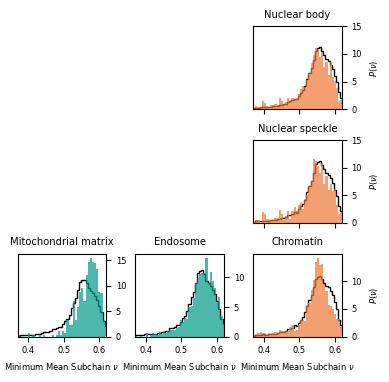

In [54]:
f, axes = plt.subplots(3, 3, sharex=True, sharey=False, figsize=(3.8,3.8))
plt.rc('font', **{'family':'sans-serif','sans-serif':['Arial'], 'size': 6})

# df_cellcom = pd.read_csv('go_analysis/GO_stats_cellcom.csv',index_col=0)
# df_cellcom.nu_p_excel = df_cellcom.nu_p.apply(lambda x: f'<{1e-10:.1g}' if x<1e-10 else f'{x:.1g}')
# df_cellcom.SPR_p_excel = df_cellcom.SPR_p.apply(lambda x: f'<{1e-10:.1g}' if x<1e-10 else f'{x:.1g}')

bin_width = .006
bins = np.arange(0.25, .74,bin_width)
x = bins[:-1]+bin_width/2.

for name,i in zip(['nuclear body','nuclear speck','mitochondrial matrix','endosome','chromatin'],[2,5,6,7,8]):
    ax = axes.flatten()[i]
    
    bool_term = df_GO_cellcom.GO_terms.apply(lambda x: name in x) 
    
    a = df_GO_cellcom[bool_term].min_mean_nu
    b = df_GO_cellcom[~bool_term].min_mean_nu
    
    h_1 = np.histogram(a,bins=bins,density=True)[0]
    h_2 = np.histogram(b,bins=bins,density=True)[0]
    
    N_IDRs = df_GO_cellcom[bool_term].shape[0]
    
    ax.hist(b,bins,density=True,histtype='step',color='k',zorder=0)
    
    alternative = 'greater'
    color = pt_colors['teal']
    if a.mean() < b.mean():
        alternative = 'less'
        color = pt_colors['orange']
    t,p = stats.ttest_ind(a, b, 
                          equal_var=False, alternative=alternative)

    # cohens_d_str = df_cellcom.loc[name,'nu_cd_excel']
    # pvalue_str = df_cellcom.loc[name,'nu_p_excel']
    # pvalue_str = '='+format_scientific(pvalue_str) if pvalue_str != '<1e-10' else '<1\\times10^{-10}'
    
    #dof = f'\nDoF: {calc_dof(a,b):,.0f}'
    
    ax.bar(x,h_1,alpha=.7,width=bin_width,color=color)
    
    if name in ['nuclear body','nuclear speck']:
        ax.set_ylim(0,15)

    if name == 'nuclear speck':
        name = 'nuclear speckle'
    
    ax.set_title(name.capitalize())
    ax.set_xlim(.37,.62)
    ax.set_xticks([.4,.5,.6])
    legend = ax.legend(handlelength=0,frameon=False,borderpad=0,loc=(-.04,.4))

    ax.yaxis.tick_right()
    ax.yaxis.set_label_position("right")
    
for ax in axes[-1,:]:
    ax.set_xlabel('Minimum Mean Subchain $\\nu$')
for ax in axes[:,2]:
    ax.set_ylabel('$P(\\nu)$')
for ax in axes[:2,:2].flatten():
    ax.axis('off')
plt.tight_layout()
#plt.savefig('figs/fig2b.pdf')
